# Dataset Analysis

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('Human_AI.csv')  # or pd.read_excel(), pd.read_json()

# Basic info
print("📄 Basic Info:")
print(df.info())

print("\n🔢 First 5 Rows:")
print(df.head())

print("\n🧭 Dataset Shape:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Check for missing values
print("\n🕳️ Missing Values:")
print(df.isnull().sum())
print("\nPercentage of Missing Values:")
print((df.isnull().mean() * 100).round(2))

# Check for duplicates
print("\n🧬 Duplicated Rows:")
print(df.duplicated().sum())

# Check data types
print("\n📦 Data Types:")
print(df.dtypes)

# Check for constant columns
print("\n🧱 Constant Columns:")
print([col for col in df.columns if df[col].nunique() == 1])

# Unique value counts
print("\n🔍 Unique Value Count per Column:")
print(df.nunique())

# Describe numeric columns
print("\n📊 Statistical Summary (Numeric):")
print(df.describe())

# Describe categorical columns
print("\n🗂️ Summary (Categorical):")
print(df.describe(include='object'))

# Value counts for categorical columns (top 3 categories)
print("\n🧾 Top Value Counts (Categorical Columns):")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col}:")
    print(df[col].value_counts().head(3))



📄 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18114 entries, 0 to 18113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      18114 non-null  object
 1   label     18114 non-null  object
 2   category  18114 non-null  object
dtypes: object(3)
memory usage: 424.7+ KB
None

🔢 First 5 Rows:
                                                text  label category
0  দেবযান – উপন্যাস – বিভূতিভূষণ বন্দ্যোপাধ্যায় ১...  human   novels
1  বরপক্ষের নিবাস কলকাতা, আজই বেলা তিনটের সময় মো...  human   novels
2  হবে, কলকাতা থেকে বরপক্ষ ভাল বাজি এনেচে। এসব পা...  human   novels
3  যতীন হেসে বল্লে–কেমন, বাজারের খাবার কিনতে হবে ...  human   novels
4  লজ্জা ও সঙ্কোচ কাটিয়ে শাশুড়ীকে জিজ্ঞেস করল–ও...  human   novels

🧭 Dataset Shape:
Rows: 18114, Columns: 3

🕳️ Missing Values:
text        0
label       0
category    0
dtype: int64

Percentage of Missing Values:
text        0.0
label       0.0
category    0.0
dtype: float64

# Model

C:\Users\Jim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/12679 [00:00<?, ? examples/s]

Map:   0%|          | 0/2717 [00:00<?, ? examples/s]

Map:   0%|          | 0/2718 [00:00<?, ? examples/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,0.001848,0.999632,0.999632
2,0.000000,0.047070,0.992271,0.992327
3,0.000000,0.000012,1.000000,1.000000



Classification Report:

              precision    recall  f1-score   support

       human       1.00      1.00      1.00      1359
          ai       1.00      1.00      1.00      1359

    accuracy                           1.00      2718
   macro avg       1.00      1.00      1.00      2718
weighted avg       1.00      1.00      1.00      2718



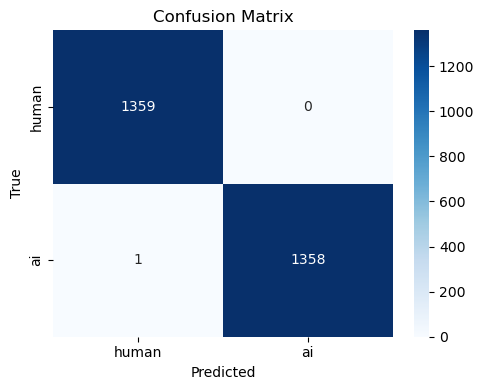

In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare dataset
df = pd.read_csv("Human_AI.csv")
df = df[['text', 'label']]
df = df[df['label'].isin(['human', 'ai'])]  # Keep only valid labels
df['label'] = df['label'].map({'human': 0, 'ai': 1})  # Encode labels

# Train/Val/Test Split: 70/15/15
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenizer
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./banglabert-human-ai",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=10,
    save_total_limit=2,
    metric_for_best_model="f1"
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Save model
model.save_pretrained("./banglabert-human-ai")
tokenizer.save_pretrained("./banglabert-human-ai")

# --------------------
# 🧪 Evaluate on test set
# --------------------
preds_output = trainer.predict(test_ds)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["human", "ai"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["human", "ai"], yticklabels=["human", "ai"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load fine-tuned model and tokenizer
model_path = "./banglabert-human-ai"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Set model to eval and move to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ Custom Bangla text input
custom_texts = [
    "আমি একজন কৃত্রিম বুদ্ধিমত্তা দ্বারা তৈরি পাঠ্য।",
    "বাংলাদেশের রাজধানী ঢাকা।",
    "এই গবেষণাটি মানুষের আবেগ চিহ্নিত করতে সহায়তা করে।",
    "বাংলাদেশ একটি সুন্দর দেশ। এর প্রকৃতি, নদ-নদী, সবুজ বনভূমি এবং পাহাড়-পর্বত আমাদের মুগ্ধ করে। আমাদের দেশের মানুষ অতিথিপরায়ণ ও পরিশ্রমী। কৃষি বাংলাদেশের প্রধান অর্থনৈতিক খাত। ধান, পাট, গম, আখ ইত্যাদি প্রধান ফসল। এছাড়াও তৈরি পোশাক শিল্প আমাদের বৈদেশিক মুদ্রা আয়ের বড় উৎস। শিক্ষাক্ষেত্রেও অগ্রগতি হচ্ছে ধীরে ধীরে। দেশের তরুণরা প্রযুক্তির প্রতি আগ্রহী হচ্ছে। তারা বিভিন্ন স্টার্টআপ ও আইটি খাতে কাজ করছে। সেবা খাত, যোগাযোগ ব্যবস্থা, ও বিদ্যুৎ খাতে উন্নয়ন লক্ষ্যণীয়। আমরা যদি সততা ও নিষ্ঠার সাথে কাজ করি, তবে বাংলাদেশ একদিন একটি উন্নত দেশে পরিণত হবে। আমাদের সবাইকে দেশপ্রেমে উদ্বুদ্ধ হয়ে কাজ করতে হবে।",
    "আমি বাংলায় কথা বলি. আমার নাম জিম. আমি আমার বাবা মা কে অনেক ভালবাসি",
    "সাম্প্রতিক সময়ে ইরান ছাড়া বিশ্বের আর কোথাও পারমাণবিক স্থাপনায় হামলার রেকর্ড নেই। তবে নির্মাণাধীন অনেক স্থাপনায় অতীতে হামলা হয়েছে। যেমন, ১৯৮০ সালে ইরান-ইরাক যুদ্ধের সময় ইরান ইরাকের নির্মাণাধীন ওসিরাক রিঅ্যাক্টরে হামলা চালায়। ১৯৮১ সালে ইসরায়েল 'অপারেশন অপেরা'র মাধ্যমে সেই রিঅ্যাক্টর ধ্বংস করে। ২০০৭ সালে সিরিয়ার একটি প্লুটোনিয়াম রিঅ্যাক্টরে ইসরায়েল হামলা চালায়। এছাড়া স্পেন, ফ্রান্স ও দক্ষিণ আফ্রিকায় রাজনৈতিক কারণে পারমাণবিক স্থাপনায় হামলার ঘটনা ঘটেছে, যদিও তাতে তেজস্ক্রিয়তা ছড়ায়নি। স্টকহোম ইন্টারন্যাশনাল পিস রিসার্চ ইনস্টিটিউটের প্রধান ড্যান স্মিথ আল জাজিরাকে জানান, বিশ্ব এখন পর্যন্ত পারমাণবিক যুদ্ধের খুব কাছাকাছি যায়নি। তবে, ভুলবশত কিছু ঘটনা ঘটেছে। যেমন—১৯৮৩ সালে সোভিয়েত ইউনিয়নে যুক্তরাষ্ট্র ক্ষেপণাস্ত্র হামলা করছে বলে তথ্য পাওয়া যায়। পরে জানা যায়, কৃত্রিম উপগ্রহ ভুল করে এমন তথ্য দেখিয়েছে।",
    "সমস্ত সকাল নগেন মড়ার মতো বিছানায় পড়ে রইল। এই চিন্তাটাই কেবল তার মনে ঘুরপাক খেতে লাগল, ভক্তি ভালোবাসার ছলনায় টাকা আদায় করে নিযেছে বলে পরলোকে গিয়েও তার ওপর মামার এমন জোরালো বিতৃষ্ণা জেগেছে যে তার তৈলচিত্রটি পর্যন্ত তিনি তাকে স্পর্শ করতে দিতে রাজি নন। যাই হোক, নগেন একালের ছেলে, প্রথম ধাক্কাটা কেটে যাবার পর তার মনে নানারকম দ্বিধা-সন্দেহ জাগতে লাগল। কে জানে রাত্রে যা ঘটেছে তা নিছক স্বপ্ন কিনা। ধৈর্য ধরতে না পেরে দুপুরবেলা সে আবার লাইব্রেরিতে গিয়ে মামার তৈলচিত্র স্পর্শ করে প্রণাম করল। একবার যদি মামা রাগ দেখিয়ে থাকেন, আবার দেখাবেন না কেন? এবার কিছুই ঘটল না। শরীরটা অবশ্য খুব খারাপ হয়ে আছে, মেঝেতে ধাক্কা যেখানে লেগেছিল মাথার সেখানটা ফুলে টনটন করছে এবং সকালে লাইব্রেরিতে মামার তৈলচিত্রের নিচে মেঝেতেই তার জ্ঞান হয়েছিল। কিন্তু এতে বড়জোর প্রমাণ হয়, রাত্রে ঘুমের মধ্যেই হোক আর জাগ্রত অবস্থাতেই হোক লাইব্রেরিতে গিয়ে সে একটা আছাড় খেয়েছিল। নিজের তৈলচিত্রে ভর করে মামাই যে তাকে ধাক্কা দিয়েছিলেন তার কী প্রমাণ আছে? নগেন যেন স্বস্তির নিশ্বাস ফেলে বাঁচল। কিন্তু বেশিক্ষণ তার মনের শান্তি টিকল না। রাত্রে আলো নিভিয়ে বিছানায় শুয়েই হঠাৎ তার মনে পড়ে গেল, তার তো ভুল হয়েছে। দিনের বেলা তাকে ধাক্কা দেয়ার ক্ষমতা তো তার মামার এখন নেই, রাত্রি ছাড়া তার মামা তো এখন কিছুই করতে পারেন না! কী সর্বনাশ!",
    "মাঠের মধ্যে এক জায়গায় কী যেন একটা শীতের ফসল রয়েছে একটা খেতে, তারই মাঝখানে দাঁড়িয়ে আছে কাকতাড়ুয়াটা। একটা খাড়া বাঁশ মাটিতে পোঁতা, তার সঙ্গে আড়াআড়িভাবে একটা বাঁশ ছড়ানো হাতের মতো দুদিকে বেরিয়ে আছে। এই হাত দুটো গলানো রয়েছে একটা ছেঁড়া জামার দুটো আস্তিনের মধ্য দিয়ে। খাড়া বাঁশটার মাথায় রয়েছে একটা উপুড় করা মাটির হাঁড়ি। দূর থেকে বোঝা যায় না, কিন্তু মৃগাঙ্কবাবু অনুমান করলেন সেই হাঁড়ির রং কালো, আর তার ওপর সাদা রং দিয়ে আঁকা রয়েছে ড্যাবা ড্যাবা চোখ-মুখ। আশ্চর্য- এই জিনিসটা পাখিরা আসল মানুষ ভেবে ভুল করে, আর তার ভয়ে খেতে এসে উৎপাত করে না। পাখিদের বুদ্ধি কি এতই কম? কুকুর তো এ ভুল করে না। তারা মানুষের গন্ধ পায়। কাক চড়ুই কি তাহলে সে গন্ধ পায় না? মেঘের মধ্যে একটা ফাটল দিয়ে রোদ এসে পড়ল কাকতাড়ুয়াটার গায়ে। মৃগাঙ্কবাবু লক্ষ করলেন যে, যে জামাটা কাকতাড়ুয়াটার গায়ে পরানো হয়েছে সেটা একটা ছিটের শার্ট। কার কথা মনে পড়ল ওই ছেঁড়া লাল-কালো ছিটের শার্টটা দেখে? মৃগাঙ্কবাবু অনেক চেষ্টা করেও মনে করতে পারলেন না। তবে কোনো একজনকে তিনি ওরকম একটা শার্ট পড়তে দেখেছেন-বেশ কিছুকাল আগে। আশ্চর্য-ওই একটি নকল প্রাণী ছাড়া আর কোনো প্রাণী নেই। মৃগাঙ্কবাবু আর ওই কাকতাড়ুয়া। এই সময়টা খেতে কাজ হয় না বলে গ্রামের মাঠেঘাটে লোকজন কম দেখা যায় ঠিকই, কিন্তু এরকম নির্জনতা মৃগাঙ্কবাবুর অভিজ্ঞতায় এই প্রথম।", 
    
]

# Tokenize and move inputs to model's device
inputs = tokenizer(custom_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Run inference
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    preds = torch.argmax(probs, dim=-1)

# Label map
label_map = {0: "human", 1: "ai"}

# Display results
for text, pred, prob in zip(custom_texts, preds, probs):
    label = label_map[pred.item()]
    confidence = prob[pred].item()
    print(f"\n📝 Text: {text}\n🔍 Predicted Label: {label} (Confidence: {confidence:.4f})")



📝 Text: আমি একজন কৃত্রিম বুদ্ধিমত্তা দ্বারা তৈরি পাঠ্য।
🔍 Predicted Label: human (Confidence: 1.0000)

📝 Text: বাংলাদেশের রাজধানী ঢাকা।
🔍 Predicted Label: human (Confidence: 1.0000)

📝 Text: এই গবেষণাটি মানুষের আবেগ চিহ্নিত করতে সহায়তা করে।
🔍 Predicted Label: ai (Confidence: 1.0000)

📝 Text: বাংলাদেশ একটি সুন্দর দেশ। এর প্রকৃতি, নদ-নদী, সবুজ বনভূমি এবং পাহাড়-পর্বত আমাদের মুগ্ধ করে। আমাদের দেশের মানুষ অতিথিপরায়ণ ও পরিশ্রমী। কৃষি বাংলাদেশের প্রধান অর্থনৈতিক খাত। ধান, পাট, গম, আখ ইত্যাদি প্রধান ফসল। এছাড়াও তৈরি পোশাক শিল্প আমাদের বৈদেশিক মুদ্রা আয়ের বড় উৎস। শিক্ষাক্ষেত্রেও অগ্রগতি হচ্ছে ধীরে ধীরে। দেশের তরুণরা প্রযুক্তির প্রতি আগ্রহী হচ্ছে। তারা বিভিন্ন স্টার্টআপ ও আইটি খাতে কাজ করছে। সেবা খাত, যোগাযোগ ব্যবস্থা, ও বিদ্যুৎ খাতে উন্নয়ন লক্ষ্যণীয়। আমরা যদি সততা ও নিষ্ঠার সাথে কাজ করি, তবে বাংলাদেশ একদিন একটি উন্নত দেশে পরিণত হবে। আমাদের সবাইকে দেশপ্রেমে উদ্বুদ্ধ হয়ে কাজ করতে হবে।
🔍 Predicted Label: human (Confidence: 0.6951)

📝 Text: আমি বাংলায় কথা বলি. আমার নাম জিম. আমি আমার বাবা 